# 1.1 Classic Dimensionality Reduction Techniques

In this demo code, we will go over classic techniques (generic bases) for dimensionality reduction:

* Fast Fourier Transform (2D images)
* Discrete Wavelet Transform (2D images)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import tensorflow as tf
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import cv2
import pywt

### Fast Fourier Transform (2D images) 

(480, 800, 3)
(480, 800)


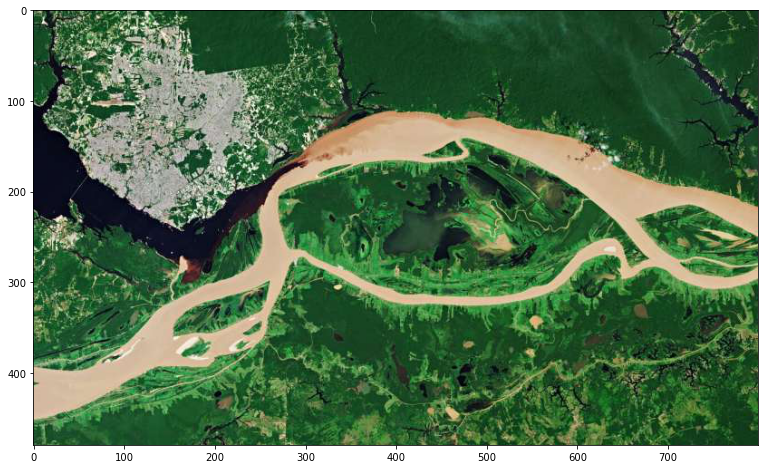

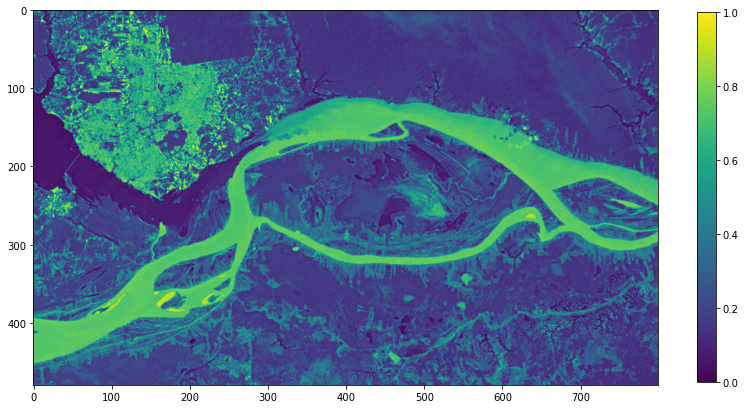

In [3]:
#download image (extracted from https://phys.org/news/2019-09-image-rio-negro-solimes-river.html)
A = imread('amazon.jpg')

plt.figure(figsize=(14, 8))
plt.imshow(A)
print(A.shape)

#convert to single channel image and normalize
A_gsc = np.mean(A, -1)/255.0

plt.figure(figsize=(14, 8))
plt.imshow(A_gsc, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.85)
print(A_gsc.shape)

D:\13108\anaconda3\envs\Py36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


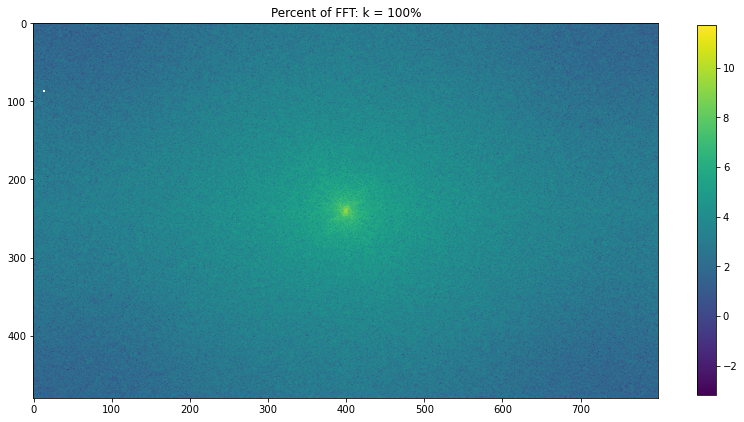

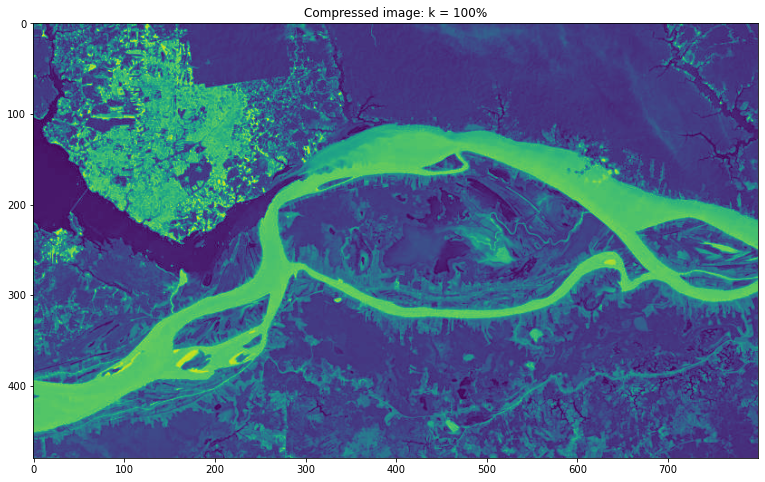

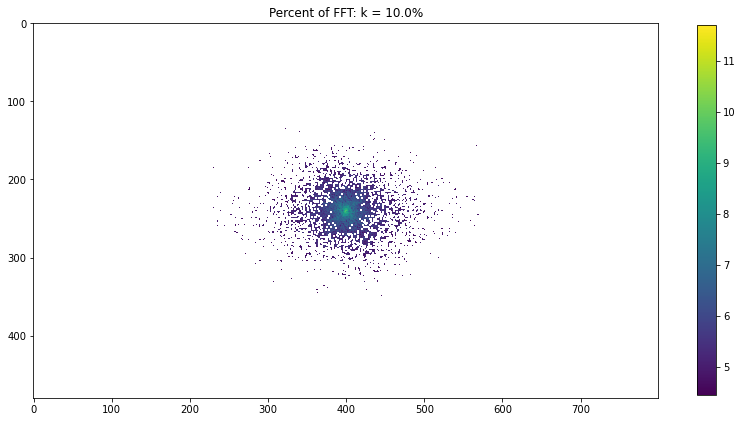

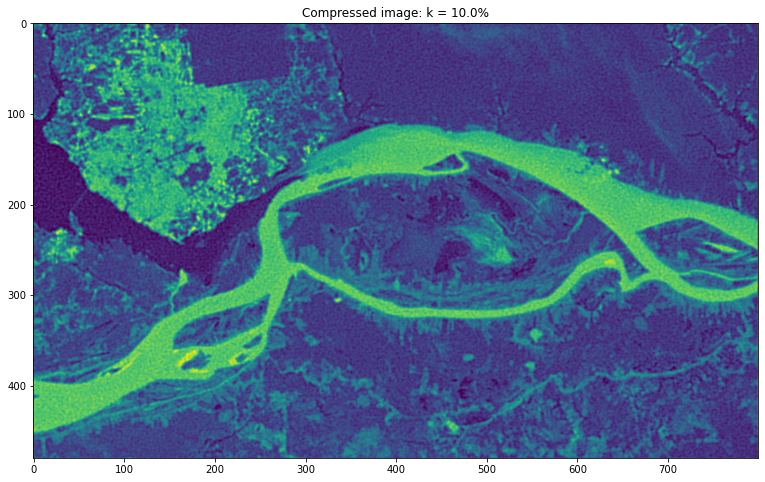

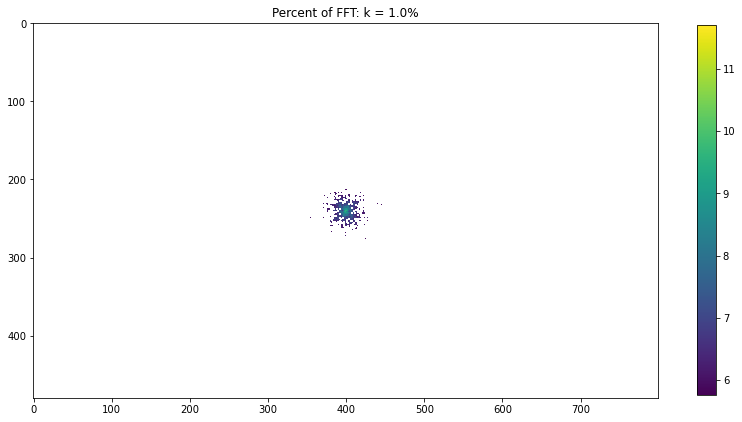

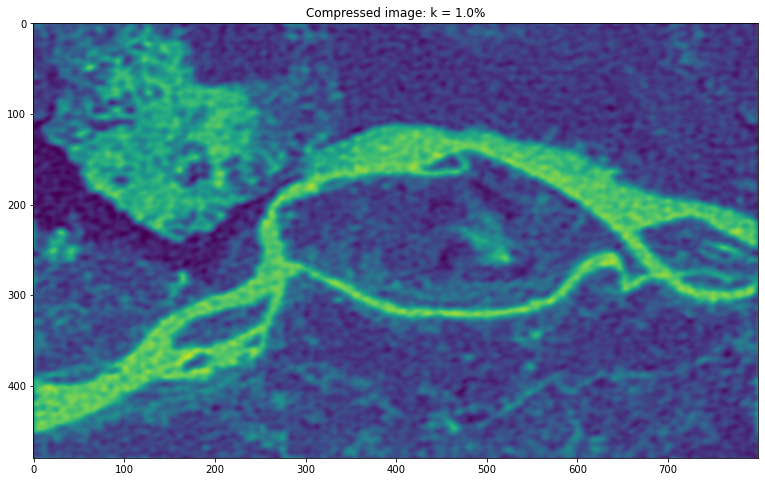

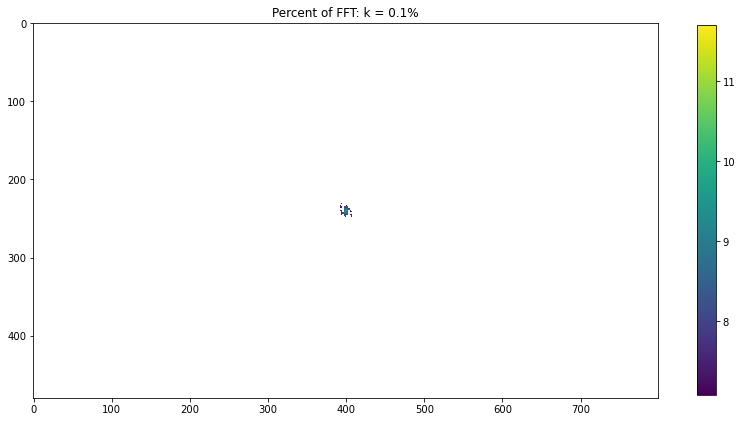

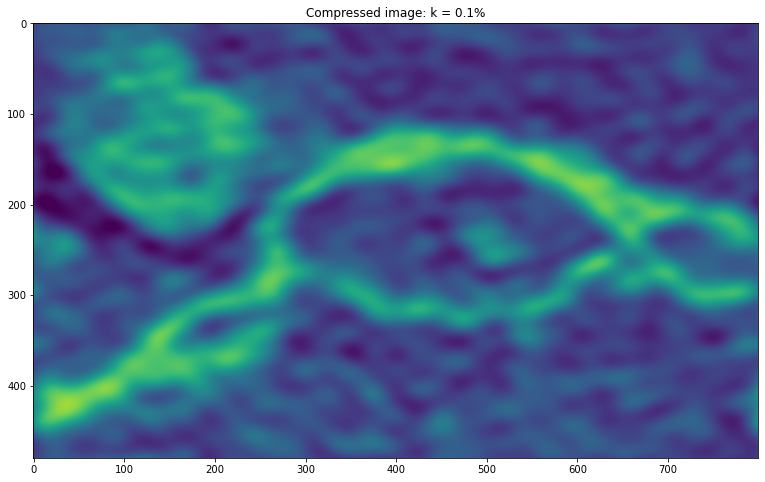

In [4]:
#compute 2D FFT (column-wiseFFT(row-wiseFFT(image)))
A_fft2 = np.fft.fft2(A_gsc)

#flatten and sort according to the magnitude
A_fft2_sort = np.sort(np.abs(A_fft2.reshape(-1)))

#zero out all small coefficients and inverse transform
ks = [1, 0.1, 0.01, 0.001]
for k in ks:
    threshold = A_fft2_sort[int(np.floor((1-k)*len(A_fft2_sort)))]    
    A_fft2_t = A_fft2 * (np.abs(A_fft2) > threshold)  
    
    #plot the thresholded coefficients
    #shift the zero frequency components to the center of the spectrum for display
    plt.figure(figsize=(14, 8))
    plt.imshow(np.fft.fftshift(np.log(np.abs(A_fft2_t))), cmap='viridis')
    plt.colorbar(shrink=0.85)
    plt.title("Percent of FFT: k = {}%".format(k*100))
    
    #inverse FFT and take only the real part
    A_ifft = np.fft.ifft2(A_fft2_t).real   
    
    plt.figure(figsize=(14, 8))
    plt.imshow(A_ifft, cmap='viridis', vmin=0, vmax=1)
    plt.title("Compressed image: k = {}%".format(k*100))

### Discrete Wavelet Transform (2D images) 

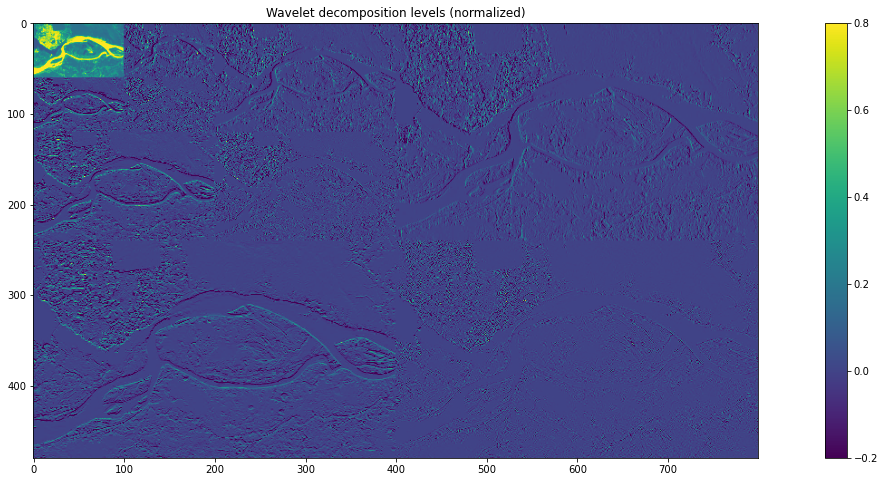

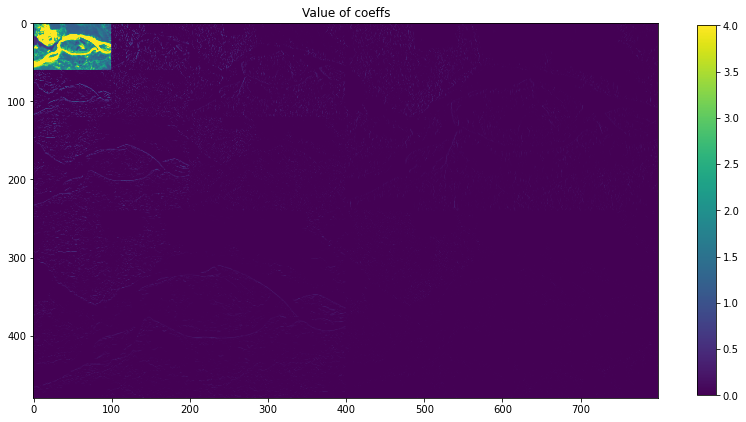

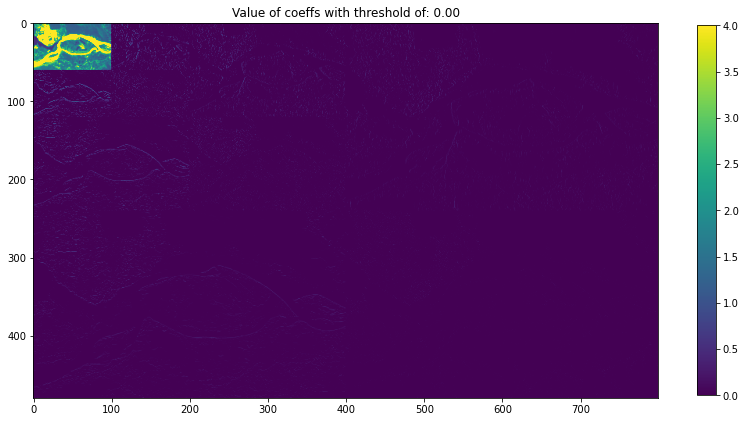

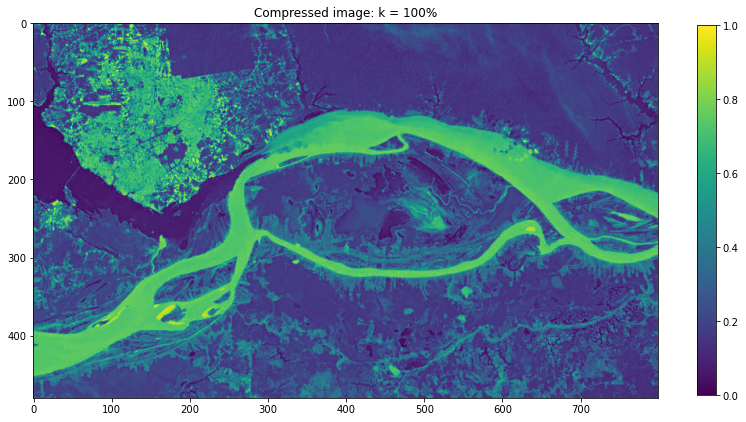

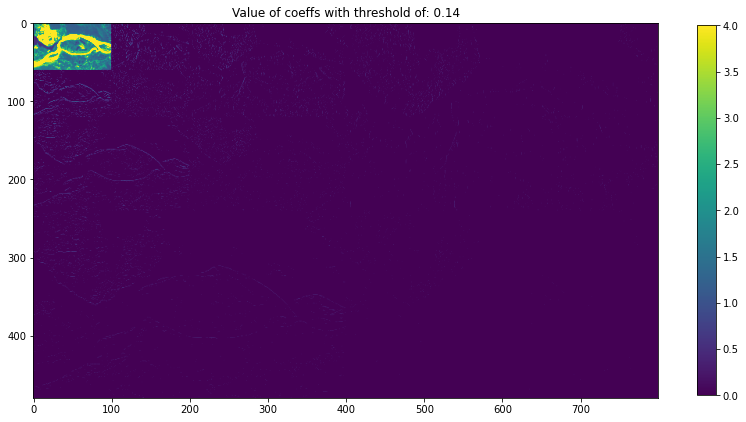

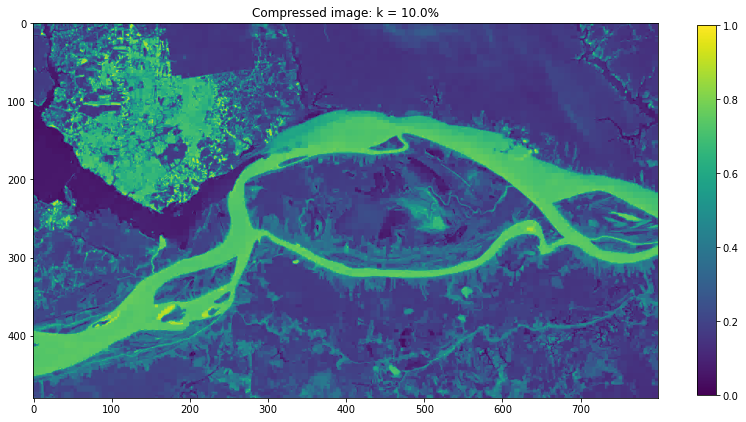

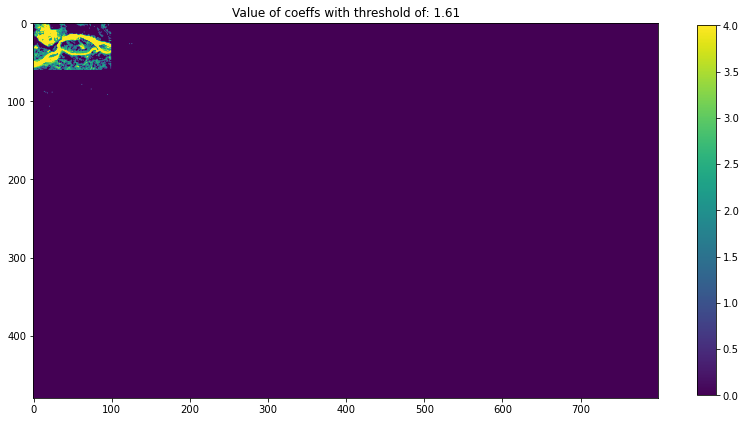

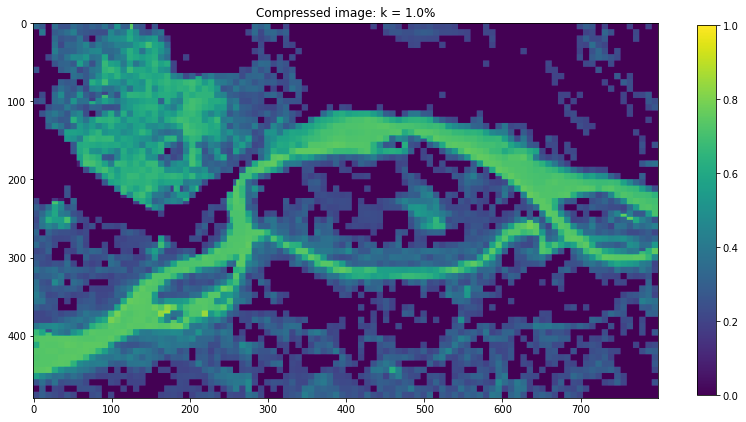

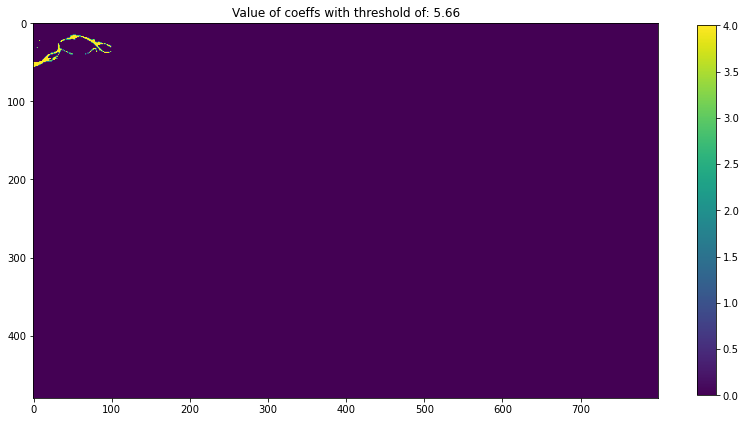

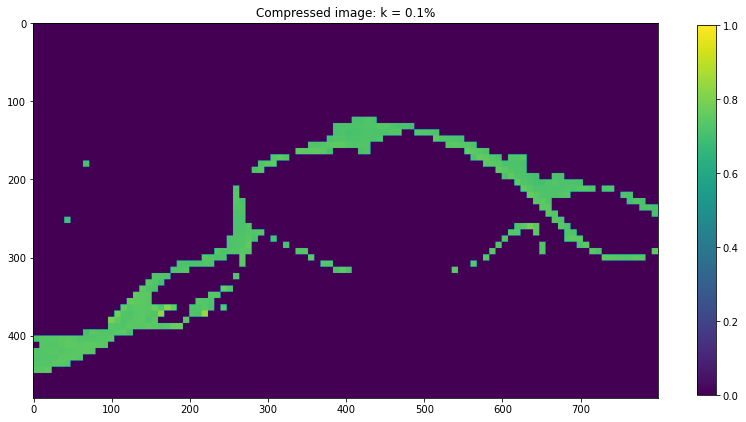

In [5]:
#wavelet multi-level decomposition is hierarchical, the first level is low resolution. The other levels will add details

#3 level wavelet decompostion
wavelet = 'db1'
level = 3
coeffs = pywt.wavedec2(A_gsc, wavelet=wavelet, level=level)

#copy the coefficients for reconstructions
import copy
coeffs_recons = copy.deepcopy(coeffs)

#coeffs has 1x(60x100), 3x(60x100), 3x(120x200), 3x(240,400)
#normalize by each level, the first level has only 1x(60x100)
coeffs[0] =  coeffs[0] / np.abs(coeffs[0]).max()

#the other levels have 3x(60x100), 3x(120x200), 3x(240,400)
for lvl in range(level):
    coeffs[lvl + 1] = [c/np.abs(c).max() for c in coeffs[lvl + 1]]

#arrange wavelet coefficient into a single array
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

#display the wavelet decompositions
plt.figure(figsize=(24, 8))
plt.imshow(coeff_arr, cmap='viridis', vmin=-0.2, vmax=0.8)
plt.colorbar(shrink=1.0)
plt.title("Wavelet decomposition levels (normalized)")

#reconstructions
#arrange wavelet coefficient into a single array
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs_recons)

#flatten to 480x800=384,000 and sort according to the magnitude
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))

plt.figure(figsize=(14, 8))
plt.imshow(np.reshape(coeff_arr.reshape(-1), [480, 800]), cmap='viridis', vmin=0, vmax=4)
plt.colorbar(shrink=0.85)
plt.title("Value of coeffs")

#zero out all small coefficients and inverse transform
ks = [1, 0.1, 0.01, 0.001]
for k in ks:
    
    #get the highest k percentage
    threshold = coeff_sort[int(np.floor((1-k)*len(coeff_sort)))]
    coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)
    
    coeffs_t = pywt.array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')
    
    #visualzie the thresholded coefficients
    plt.figure(figsize=(14, 8))
    plt.imshow(np.reshape(coeff_arr_t.reshape(-1), [480, 800]), cmap='viridis', vmin=0, vmax=4)
    plt.colorbar(shrink=0.85)
    plt.title("Value of coeffs with threshold of: {:.2f}".format(threshold))
    
    # Plot reconstruction
    A_gsc_recons = pywt.waverec2(coeffs_t, wavelet=wavelet)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(A_gsc_recons, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(shrink=0.85)
    plt.title("Compressed image: k = {}%".format(k*100))